# Apartat C

## Setup

* Importem les llibreries
* Configurem pandas
* Importem el dataset
* Inspeccionem les dimensions de les dades

In [145]:
## APARTADO C

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualitzarem 4 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.4f' % x)

dataset = pd.read_csv("Consumo_cerveja.txt", header=0, delimiter=',', decimal=".", names=["DATA","TEMPMED","TEMPMIN","TEMPMAX","PREC","FINSEM","CONSUM"])
dataset = dataset.assign(DIFERENCIA= dataset.TEMPMAX - dataset.TEMPMIN)
dataset = dataset.assign(TEMPMITJA= (dataset.TEMPMAX + dataset.TEMPMIN + dataset.TEMPMED)/3)
dataset = dataset[["DATA","TEMPMED","TEMPMIN","TEMPMAX","PREC","FINSEM","DIFERENCIA", "TEMPMITJA", "CONSUM"]]
data = dataset.values
x = data[:, 1:-1]
y = data[:, -1]

print("Dimensionalitat de la BBDD:", dataset.shape)
print("Dimensionalitat de les entrades X", x.shape)
print("Dimensionalitat de l'atribut Y", y.shape)


Dimensionalitat de la BBDD: (365, 9)
Dimensionalitat de les entrades X (365, 7)
Dimensionalitat de l'atribut Y (365,)


## Mostrem les característiques del dataset

* Número d'entrades
* Descripció de les columnes
    * Nom de cada columna
    * Quantitat de registres amb valor
    * Si pot ser null o no
    * Tipus de dada

La part del tipus de dada es especialment important. Si les dades no s'importen com a números no podrem treballar correctament amb el dataset.

In [146]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATA        365 non-null    object 
 1   TEMPMED     365 non-null    float64
 2   TEMPMIN     365 non-null    float64
 3   TEMPMAX     365 non-null    float64
 4   PREC        365 non-null    float64
 5   FINSEM      365 non-null    int64  
 6   DIFERENCIA  365 non-null    float64
 7   TEMPMITJA   365 non-null    float64
 8   CONSUM      365 non-null    int64  
dtypes: float64(6), int64(2), object(1)
memory usage: 25.8+ KB


## Busquem valors nulls

No n'hi ha cap.

In [147]:
print("Per comptar el nombre de valors no existents:")
print(dataset.isnull().sum())

Per comptar el nombre de valors no existents:
DATA          0
TEMPMED       0
TEMPMIN       0
TEMPMAX       0
PREC          0
FINSEM        0
DIFERENCIA    0
TEMPMITJA     0
CONSUM        0
dtype: int64


## Visualitzem els primers registres

In [148]:
print("Per visualitzar les primeres 5 mostres de la BBDD:")
dataset.head()

Per visualitzar les primeres 5 mostres de la BBDD:


,DATA,TEMPMED,TEMPMIN,TEMPMAX,PREC,FINSEM,DIFERENCIA,TEMPMITJA,CONSUM
0,2015-01-01,27.3000,23.9000,32.5000,0.0000,0,8.6000,28.2000,25461
1,2015-01-02,27.0200,24.5000,33.5000,0.0000,0,9.0000,29.0000,28972
2,2015-01-03,24.8200,22.4000,29.9000,0.0000,1,7.5000,26.1500,30814
3,2015-01-04,23.9800,21.5000,28.6000,1.2000,1,7.1000,25.0500,29799
4,2015-01-05,23.8200,21.0000,28.3000,0.0000,0,7.3000,24.6500,28900


In [149]:
print("Per veure estadístiques dels atributs numèrics de la BBDD:")
dataset.describe()

Per veure estadístiques dels atributs numèrics de la BBDD:


,TEMPMED,TEMPMIN,TEMPMAX,PREC,FINSEM,DIFERENCIA,TEMPMITJA,CONSUM
count,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000,365.0000
mean,21.2264,17.4614,26.6115,5.1967,0.2849,9.1501,22.0364,25401.3671
std,3.1801,2.8262,4.3174,12.4178,0.4520,3.1946,3.2806,4399.1427
min,12.9000,10.6000,14.5000,0.0000,0.0000,2.5000,12.7500,14343.0000
25%,19.0200,15.3000,23.8000,0.0000,0.0000,6.7000,19.9000,22008.0000
50%,21.3800,17.9000,26.9000,0.0000,0.0000,9.4000,22.2000,24867.0000
75%,23.2800,19.6000,29.4000,3.2000,1.0000,11.4000,24.3000,28631.0000
max,28.8600,24.5000,36.5000,94.8000,1.0000,18.1000,29.6000,37937.0000


## Mostrem correlacions

Mostrem les correlacions entre els atributs numerics.

El que ens importa especialment son les correlacions entre l'atribut de consum i la resta d'atributs.

Utilitzem el seguent criteri per les correlacions segons el seu valor absolut:
* \[0, 0.3) -> sense correlacio
* \[0.3, 0.5) -> correlacio baixa
* \[0.5, 0.7) -> correlacio mitja
* \[0.7, 0.9) -> correlacio alta
* \[0.9, 1\] -> correlacio molt alta

Veiem les seguents correlacions:
* Consum i temperatura mitjana: correlacio mitja
* Consum i temperatura minima: correlacio baixa
* Consum i temperatura maxima: correlacio mitja
* Consum i precipitacio: sense correlacio
* Consum i cap de setmana: correlacio mitja
      
No hi ha cap variable que tingui correlacio alta o molt alta amb el consum.
    

També hi ha correlacions mitjes o altes entre les diferents mostres de temperatures (minima, mitjana, maxima).

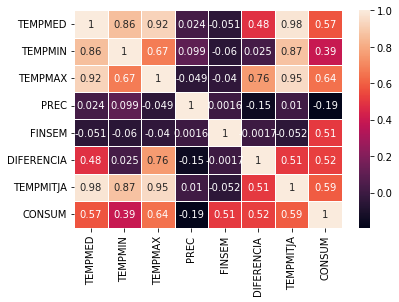

In [150]:
co = dataset.corr()
plt.figure()

ax = sns.heatmap(co, annot=True, linewidths=.5)

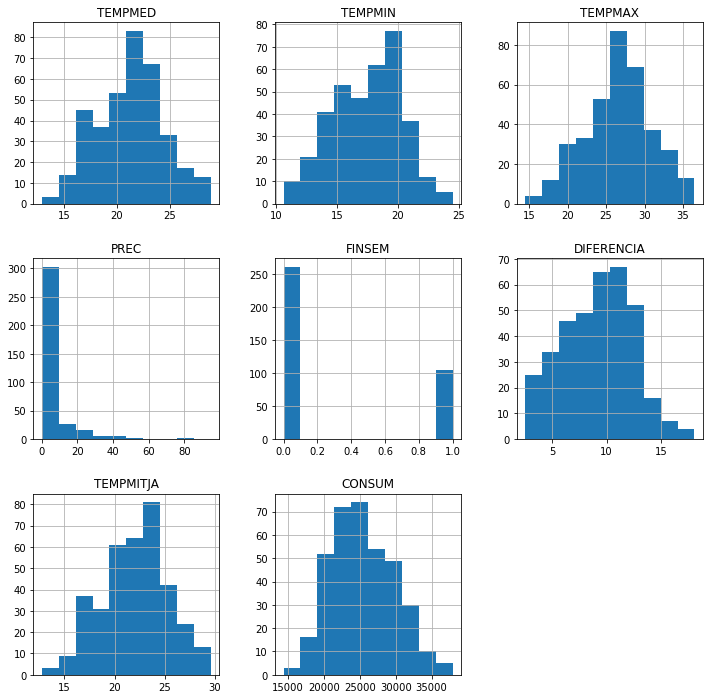

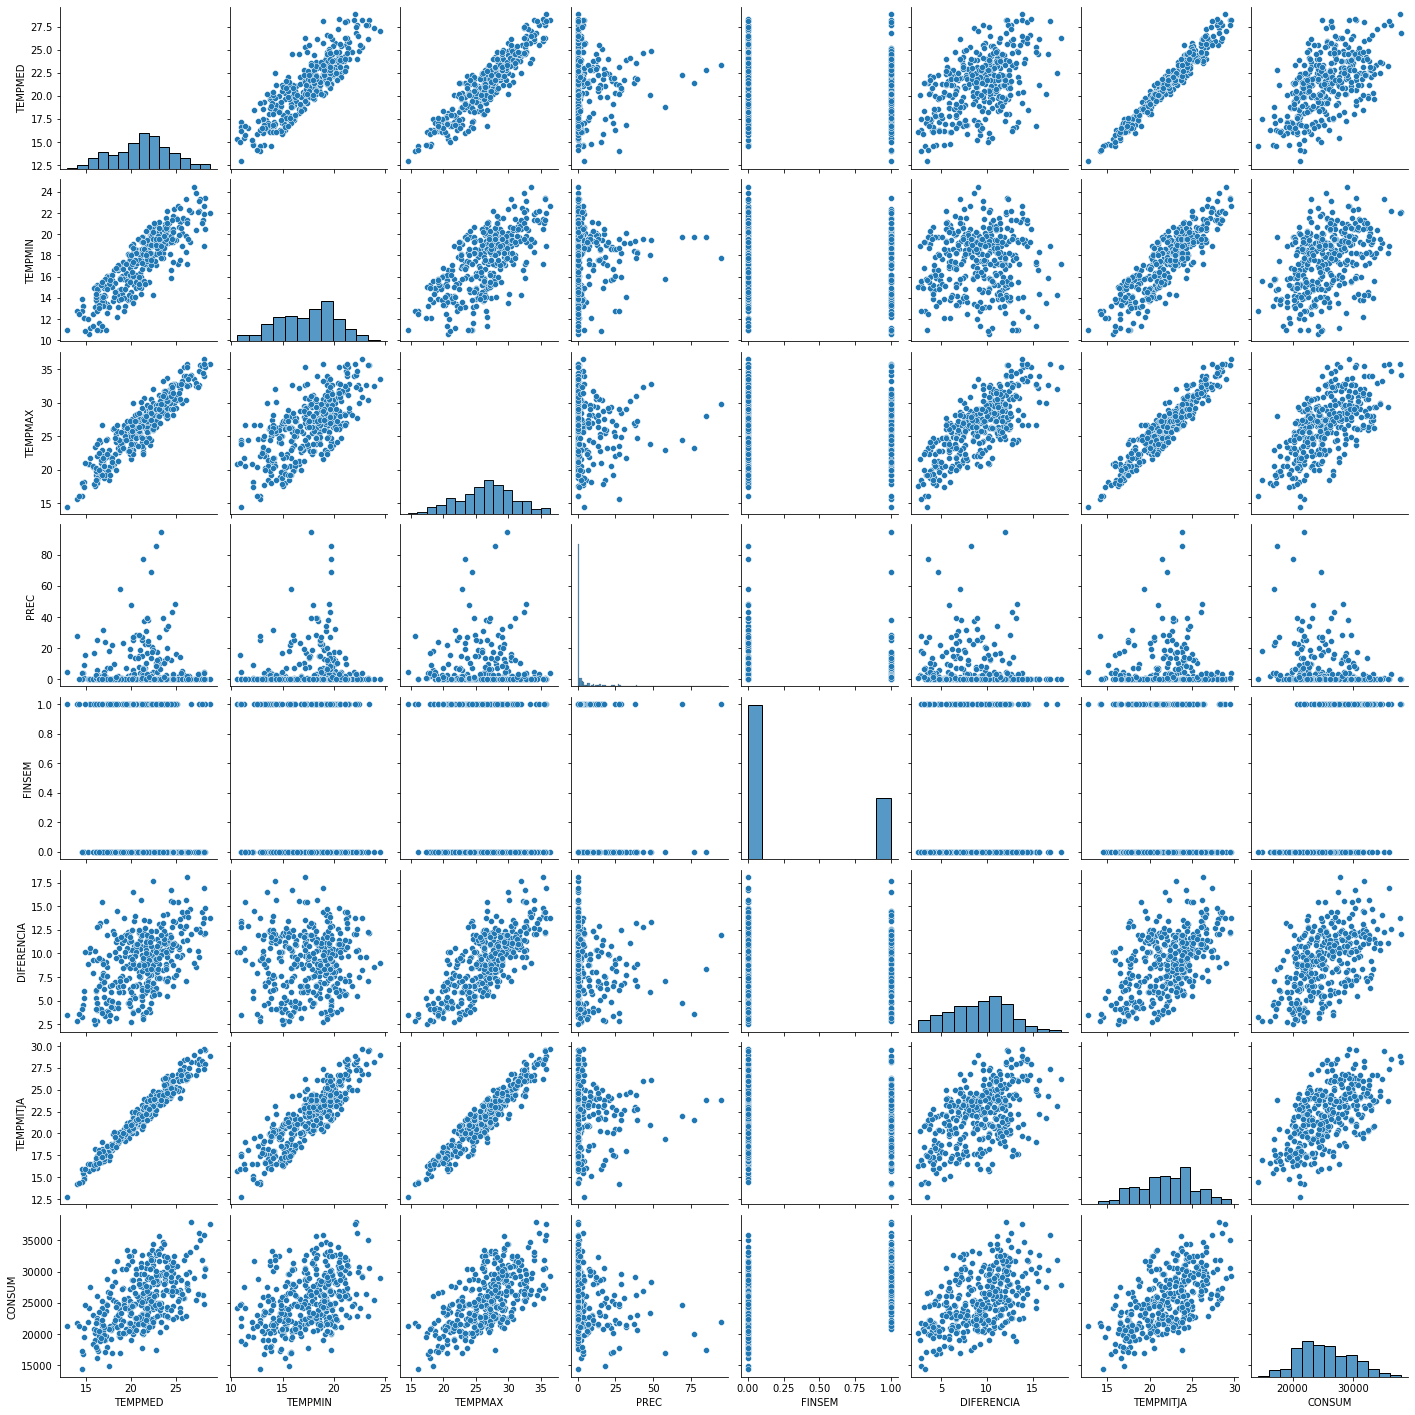

In [151]:
dataset.hist(figsize=(12, 12))
rel = sns.pairplot(dataset)

## Descartem atributs

Com que les precipitacions no tenen correlacio amb el consum, i tampoc segueixen una distribució Gaussiana, el descartem.
Com que la temperatura mínima te correlació baixa, la descartem també.
I com hem descartat alguns valors, actualitzem els valors a x.

In [152]:
dataset2 = dataset.drop(['PREC'], axis=1)

data = dataset2.values
x = data[:, 1:-1]
y = data[:, -1]

# Apartat B

In [153]:
## APARTADO B

import math
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import train_test_split

def mse(v1, v2):
    return ((v1 - v2)**2).mean()

def linearReg(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()
    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)
    # Retornem el model entrenat
    return regr

def lassoReg(x, y):
    regr = Lasso()
    regr.fit(x, y)
    return regr

def ridgeReg(x, y):
    regr = Ridge()
    regr.fit(x, y)
    return regr

def elasticReg(x, y):
    regr = ElasticNet()
    regr.fit(x, y)
    return regr


In [154]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x = x.astype(float)
y = y.astype(float)

x = standarize(x)


In [155]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

from sklearn.metrics import r2_score

regr = linearReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Linear Regression:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = lassoReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Lasso:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = ridgeReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("Ridge:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

regr = elasticReg(x_train, y_train)
error = mse(y_test, regr.predict(x_test)) # calculem error
r2 = r2_score(y_test, regr.predict(x_test))
print("ElasticNet:")
print("Error en atribut: %f" %( error))
print("R2 score en atribut: %f" %( r2))

Linear Regression:
Error en atribut: 6557243.603402
R2 score en atribut: 0.606448
Lasso:
Error en atribut: 6547193.949446
R2 score en atribut: 0.607051
Ridge:
Error en atribut: 6526957.998728
R2 score en atribut: 0.608266
ElasticNet:
Error en atribut: 6310288.050417
R2 score en atribut: 0.621270


In [156]:
# APARTADO A

import numpy as np

class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        self.weights = self.weights - self.alpha / m * (X.transpose() * (X * self.weights - y));
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        iterations = 0            
        pass
    
    
class RegressorProba(object):
    def __init__(self, w0, weights, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.weights = weights
        self.alpha = alpha
        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        return np.dot(x, self.weights) + self.w0
    
    def __update(self, X, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        m = len(y)
        self.weights = self.weights - self.alpha / m * (X.transpose() * (X * self.weights - y));
        
    def __gradients(self, x, real_y, predicted_y):
        error = predicted_y - real_y
        w0_gradient = (1 / len(real_y)) * np.sum(error)
        weights_gradients = (1 / len(real_y)) * np.matmul(x.transpose(), error)
        
        return w0_gradient, weights_gradients
        
    def __update_weights(self, w0_diff, weight_diffs):
        self.w0 = self.w0 - self.alpha * w0_diff
        self.weights = self.weights - self.alpha * weight_diffs
    
    def train(self, x, y, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        iterations = 0
        old_w0 = self.w0
        old_weights = self.weights.copy()
        while iterations < max_iter:
            predicted_y = self.predict(x)
            
            w0_diff, weight_diffs = self.__gradients(x, y, predicted_y)
                        
            self.__update_weights(w0_diff, weight_diffs)
    
            if abs(self.w0 - old_w0) < epsilon and np.allclose(self.weights, old_weights, atol=epsilon):
                return
            
            old_w0 = self.w0
            old_weights = self.weights
            iterations += 1

            
regr = RegressorProba(1, np.ones(len(x_train[0]), dtype=float), 0.1)

regr.train(x_train, y_train, 100000, 0.001)

y_predict = regr.predict(x_test)

error = mse(y_test, y_predict) # calculem error
r2 = r2_score(y_test, y_predict)
print("CUSTOM Linear Regression:")
print("Error: %f" %( error))
print("R2 score: %f" %( r2))


CUSTOM Linear Regression:
Error: 6556862.793601
R2 score: 0.606471
